In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

# Look at a Map

In [197]:
t11, t12, t22 = hp.read_map("../outputs/out_2MASS_XSC_EQ/tidal_sm2.0.fits", field=[2,3,4])
npix = len(t11)

NSIDE = 64
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


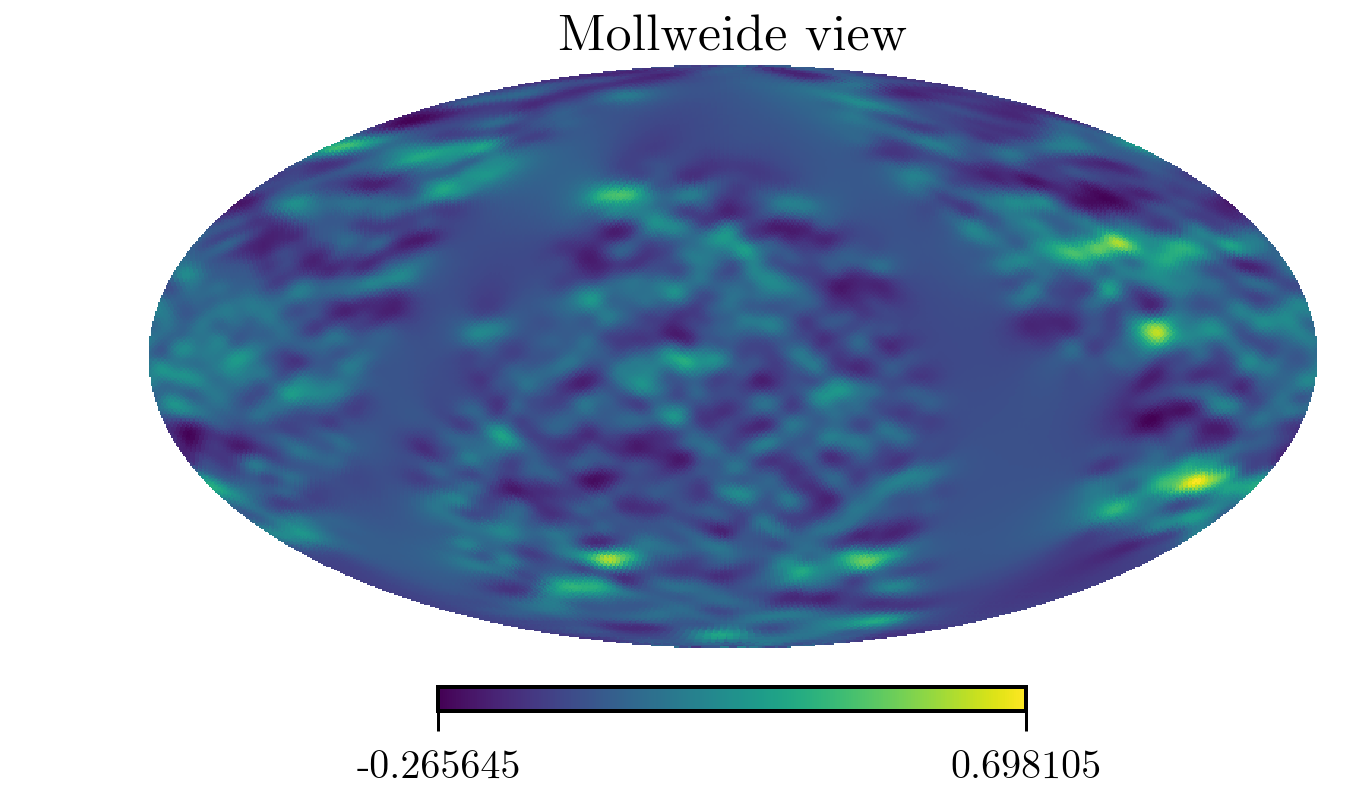

In [198]:
hp.mollview(t11)

# Generate Eigenvectors

First, we generate a big stack of 2x2 arrays.

In [199]:
array_stack = np.zeros( (npix, 2, 2) ) # long axis is first
array_stack[:,0,0] = t11
array_stack[:,1,0] = t12
array_stack[:,0,1] = t12
array_stack[:,1,1] = t22

Then we compute the eigenvalues and eigenvectors.

In [200]:
w,v = np.linalg.eig(a=array_stack)

We need to select the principal eigenvector.

In [201]:
principal_eig_ind = np.argmax( np.abs(w), axis=1 )
principal_eigenvectors = np.array( [v[i,:,principal_eig_ind[i]] for i in range(npix)] )
principal_eigenvalues = np.array( [w[i,principal_eig_ind[i]] for i in range(npix)] )

In [202]:
array_stack[0,:,:]

array([[ 0.00406811,  0.18131779],
       [ 0.18131779, -0.00417679]])

In [203]:
v[0][1]

array([0.69902426, 0.71509795])

In [204]:
np.linalg.eig(array_stack[0,:,:])

(array([ 0.18131031, -0.18141899]), array([[ 0.71509795, -0.69902426],
        [ 0.69902426,  0.71509795]]))

Let's test that they are indeed eigenvectors, by computing $ A v - \lambda v $.

In [205]:
diffs = np.array([
    np.dot( array_stack[i], principal_eigenvectors[i] ) - (principal_eigenvalues[i] * principal_eigenvectors[i])
         for i in range(npix)])

In [206]:
np.max(diffs)

1.1102230246251565e-16

We see that these are indeed eigenvalues and eigenvectors.

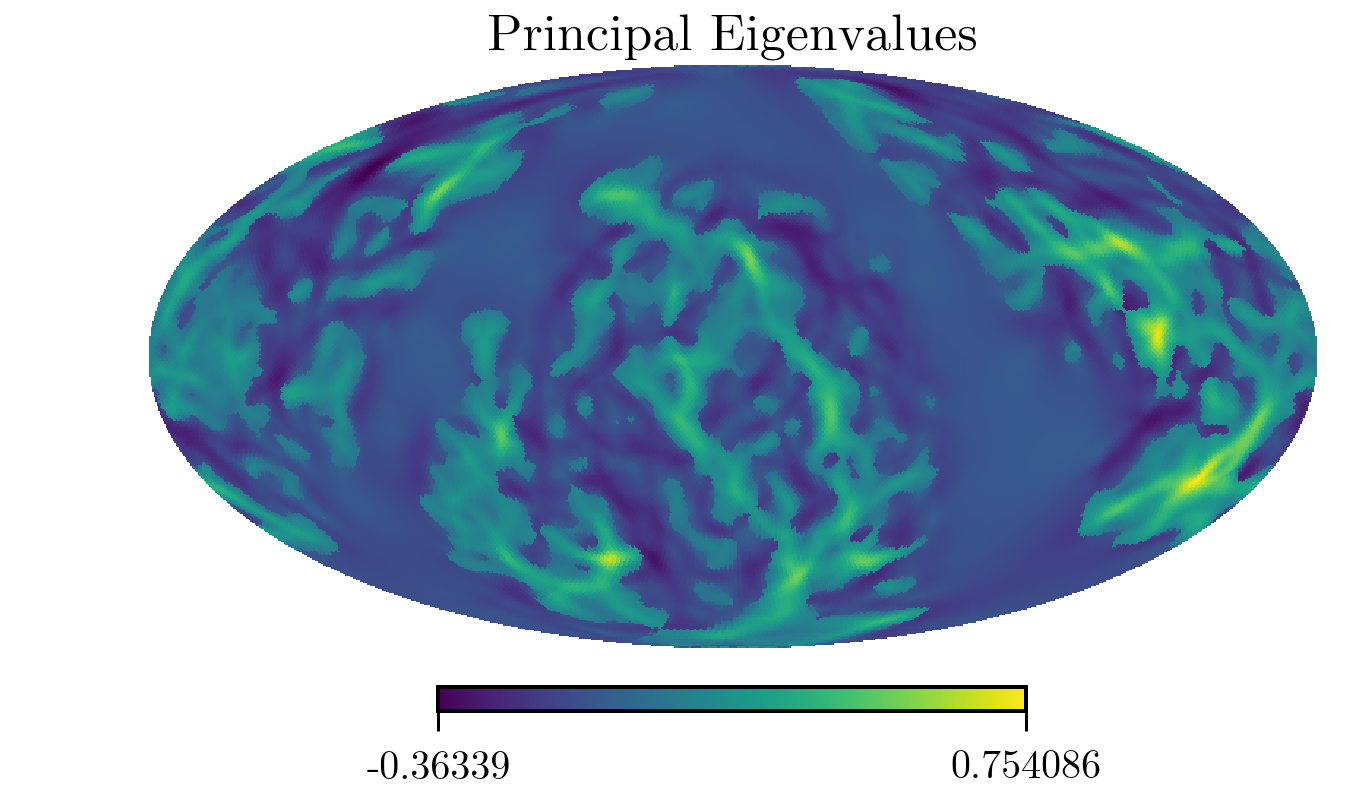

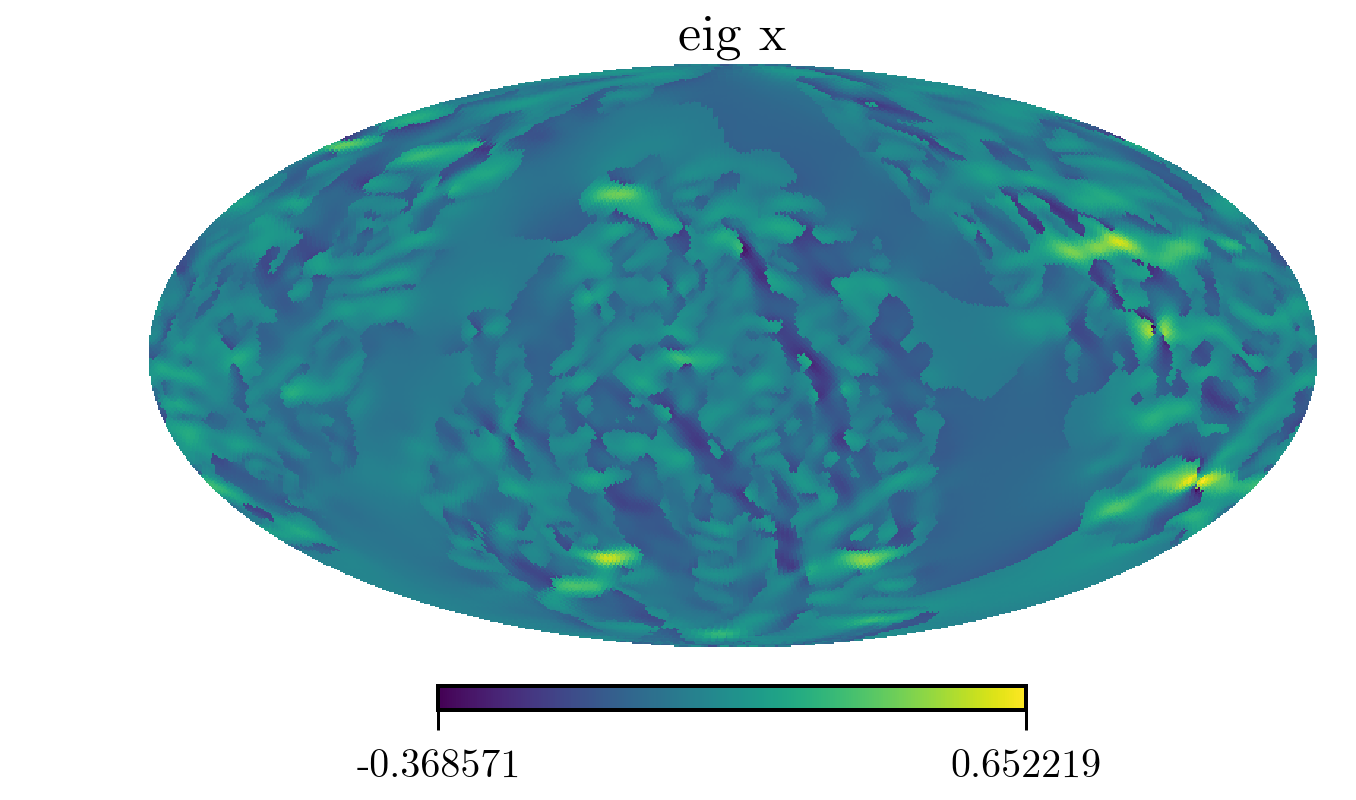

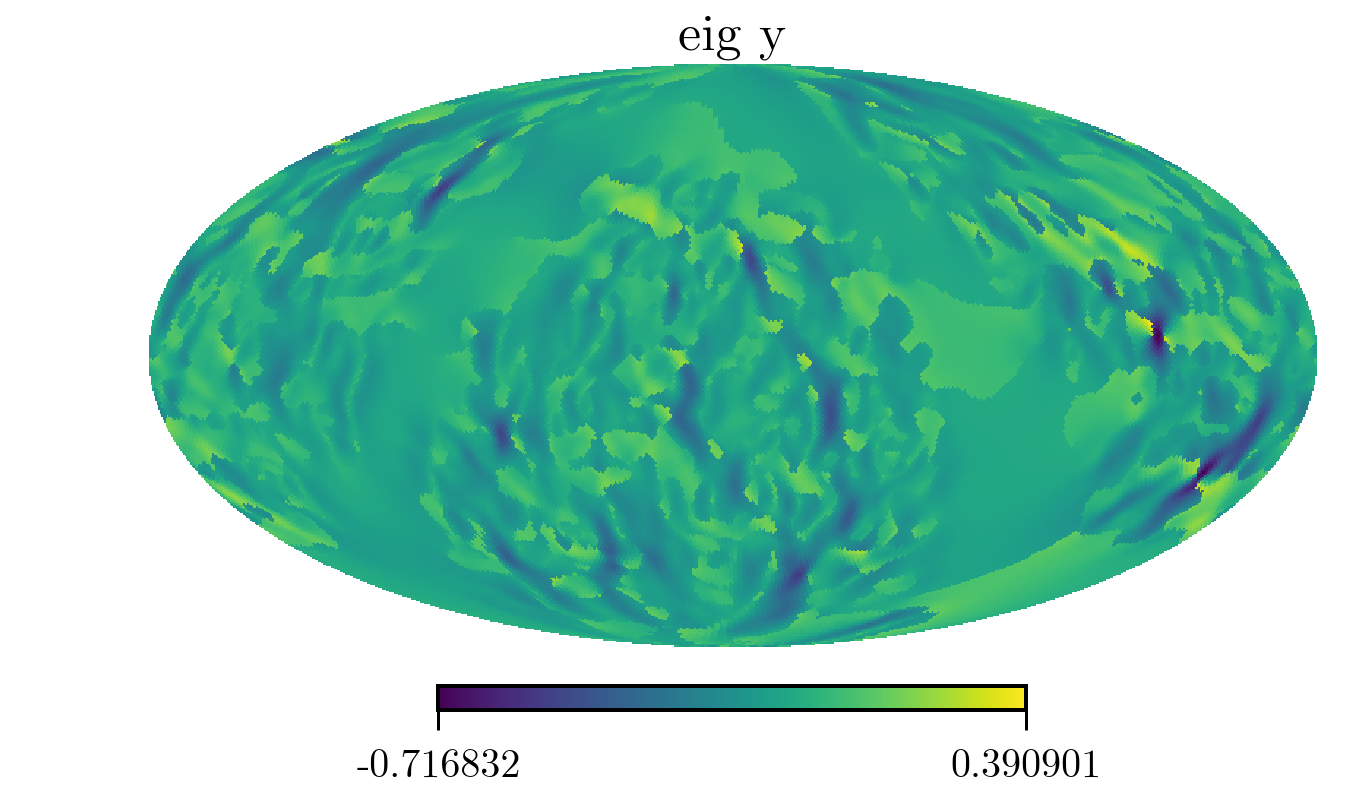

In [226]:
hp.mollview(principal_eigenvalues, title="Principal Eigenvalues")
hp.mollview(principal_eigenvalues * principal_eigenvectors[:,0], title="eig x")
hp.mollview(principal_eigenvalues * principal_eigenvectors[:,1], title="eig y")

# Dot Product

In [208]:
from astropy.io import fits

hdu = fits.open("../data/2MASS_XSC.fits")
galaxy_data = hdu[1].data

# galaxy_data = galaxy_data[ galaxy_data['j_m_k20fe'] < 12 ]

In [209]:
nside = hp.get_nside(t11)
pixels_from_angles = hp.ang2pix( nside=nside, phi=galaxy_data['dec'], theta=galaxy_data['ra'], lonlat=True )

In [282]:
amp = (1-galaxy_data['j_ba'])
phi_x = -amp * np.cos((90-galaxy_data['j_phi']) * np.pi / 180)
phi_y = amp * np.sin((90-galaxy_data['j_phi']) * np.pi / 180)

In [277]:
eigenvectors_per_galaxy_x = principal_eigenvectors[pixels_from_angles,0]
eigenvectors_per_galaxy_y = principal_eigenvectors[pixels_from_angles,1]

In [278]:
dot_product = (phi_x * eigenvectors_per_galaxy_x) + (phi_y * eigenvectors_per_galaxy_y)
dot_product *= (principal_eigenvalues[pixels_from_angles])

(array([5.00000e+00, 7.79814e+05, 1.00240e+05, 1.53182e+05, 1.03553e+05,
        9.49550e+04, 9.71160e+04, 1.17499e+05, 1.09066e+05, 9.14140e+04]),
 array([-0.4712389 , -0.11170107,  0.24783675,  0.60737458,  0.96691241,
         1.32645023,  1.68598806,  2.04552588,  2.40506371,  2.76460154,
         3.12413936]),
 <a list of 10 Patch objects>)

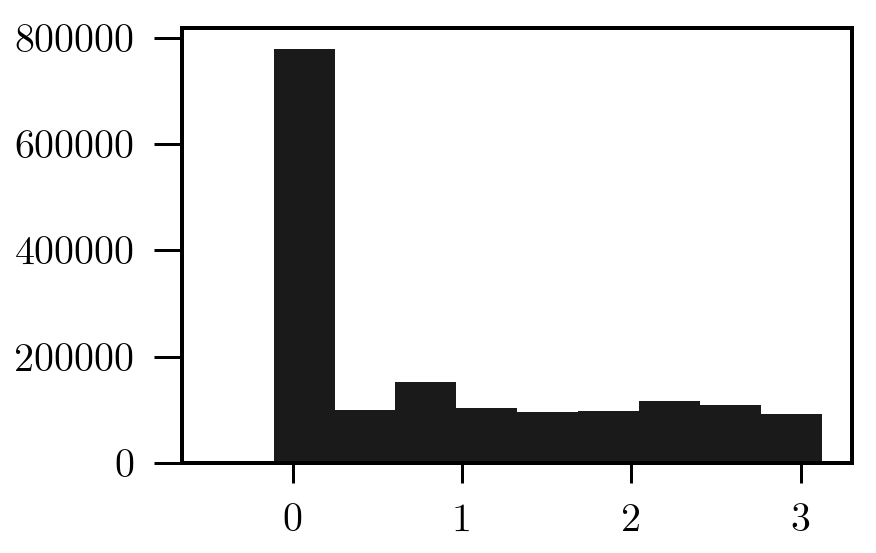

In [290]:
plt.hist( ((90-galaxy_data['j_phi']) * np.pi / 180) )

In [293]:
uniform_random_theta = np.random.rand( len(galaxy_data) ) * 2 * np.pi
uniform_x = amp * np.cos(uniform_random_theta)
uniform_y = np.abs(amp * np.sin(uniform_random_theta))

uniform_dot = (uniform_x * eigenvectors_per_galaxy_x) + (uniform_y * eigenvectors_per_galaxy_y)
uniform_dot *= (principal_eigenvalues[pixels_from_angles])

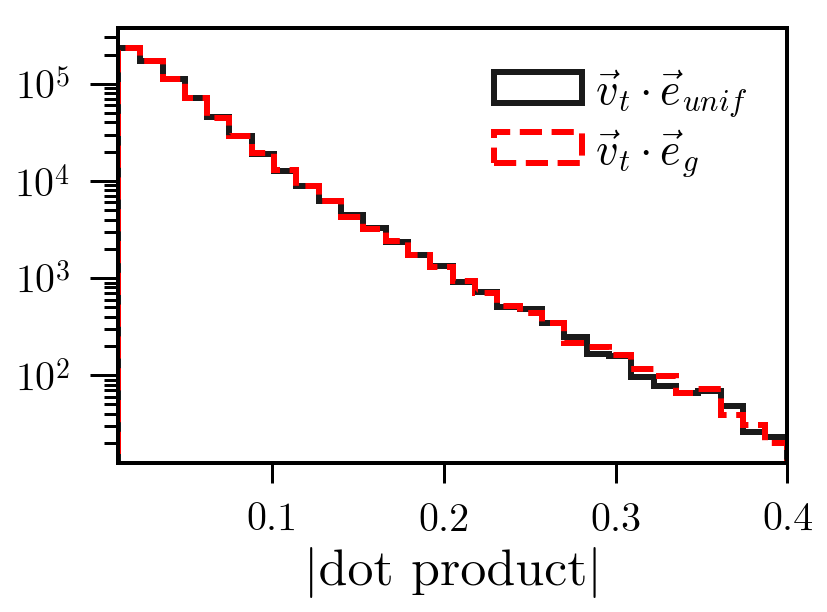

In [294]:
counts_u, bins_u, patches = plt.hist( np.abs(uniform_dot), range=(0.01,0.4), bins=30,
         histtype="step", label=r"$\vec{v}_t \cdot \vec{e}_{unif}$" );

counts_g, bins_g, patches = plt.hist( np.abs(dot_product), range=(0.01,0.4), bins=30,
         histtype="step", label=r"$\vec{v}_t \cdot \vec{e}_g$", color="red", ls="dashed", );

plt.legend()

plt.xlabel("|dot product|")
plt.xlim(0.01,0.4)
plt.yscale('log')

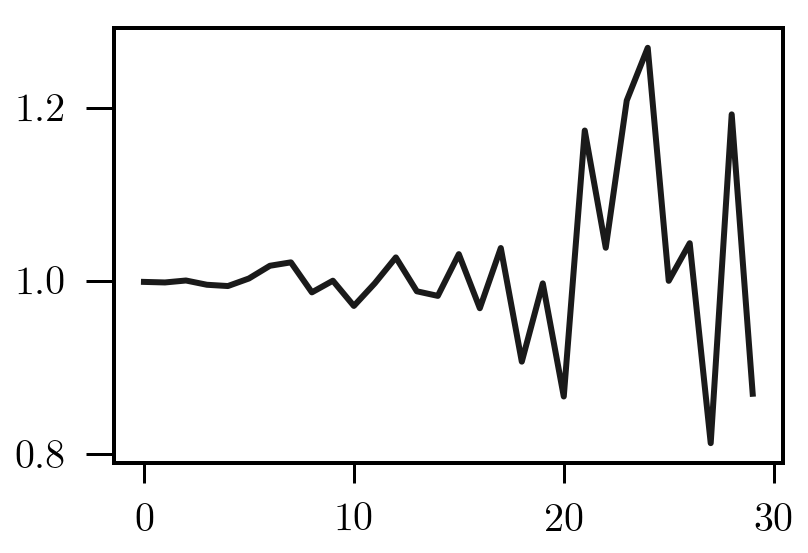

In [295]:
plt.plot( counts_g / counts_u )

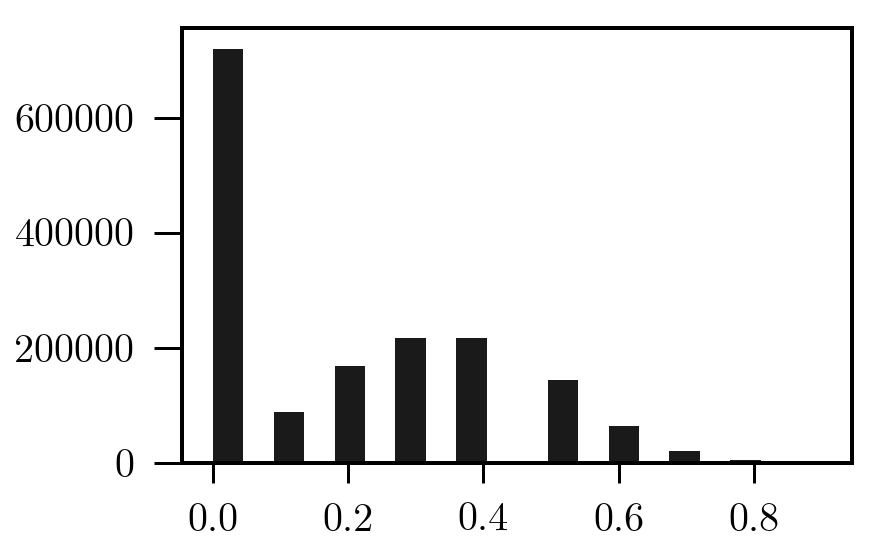

In [296]:
plt.hist( amp, bins=20 );

# Binning By Pixel

NSIDE = 64
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


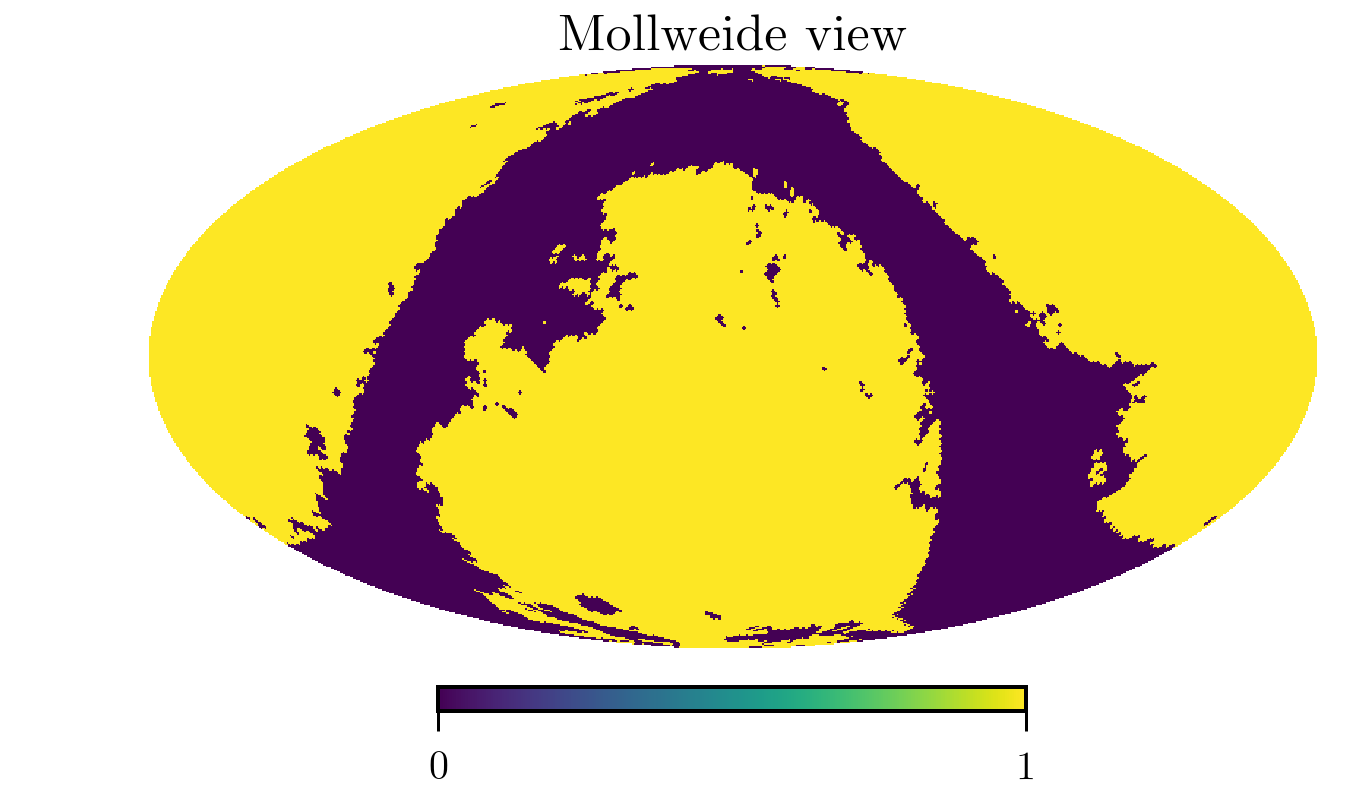

In [297]:
mask = hp.read_map("../outputs/out_2MASS_XSC_EQ/mask.fits")
hp.mollview(mask)

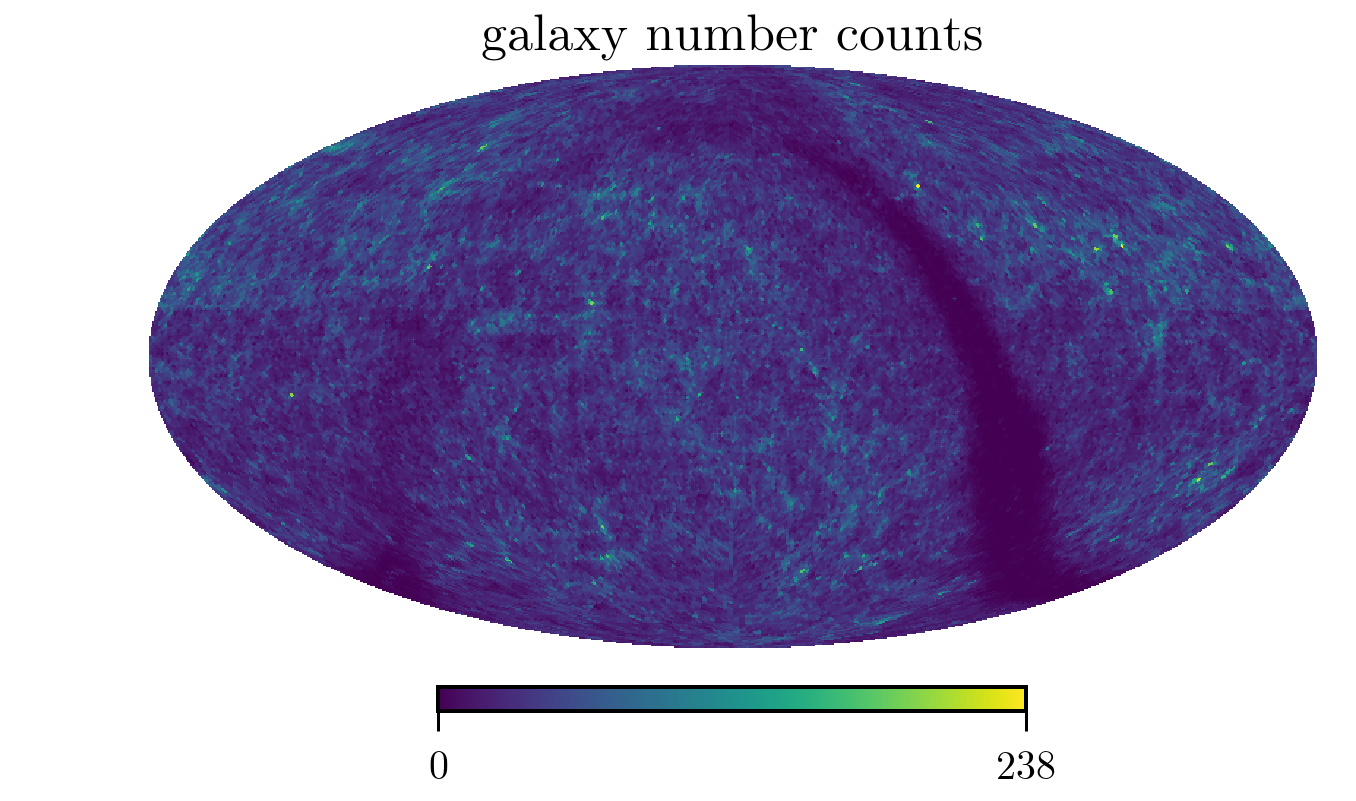

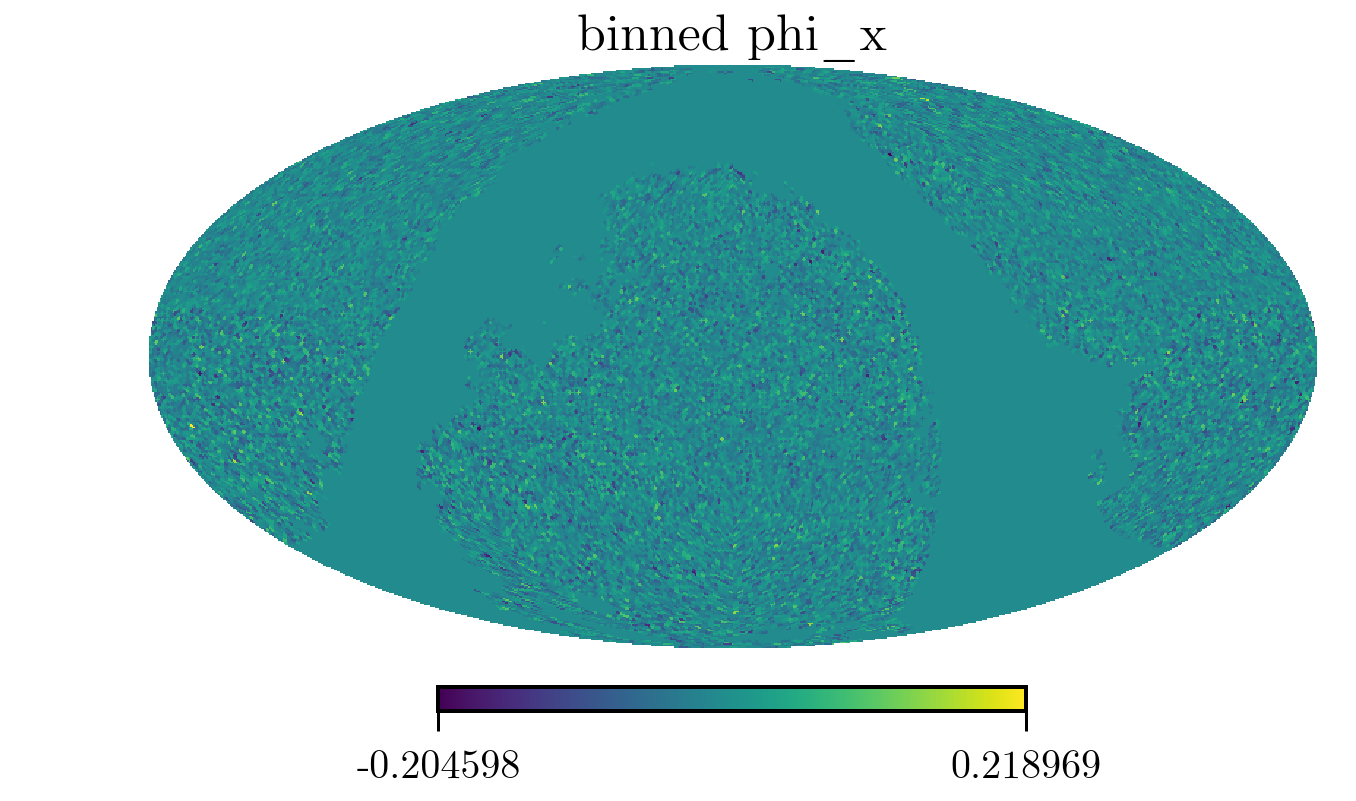

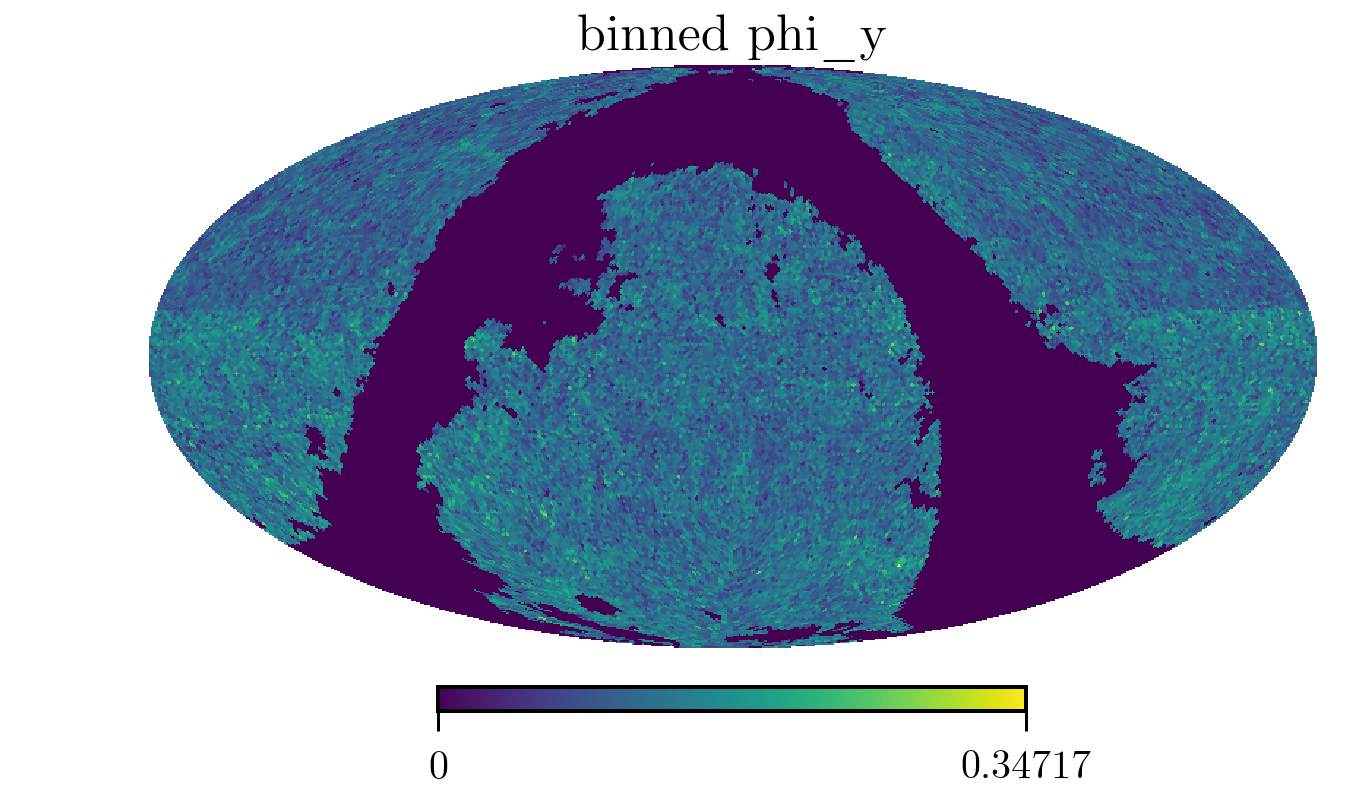

In [298]:
phi_x_pixel = np.zeros(npix)
phi_y_pixel = np.zeros(npix)
counts_per_pixel = np.zeros(npix)

np.add.at(counts_per_pixel, pixels_from_angles, 1)
np.add.at(phi_x_pixel, pixels_from_angles, phi_x)
np.add.at(phi_y_pixel, pixels_from_angles, phi_y)

phi_x_pixel /= counts_per_pixel
phi_y_pixel /= counts_per_pixel
phi_x_pixel[counts_per_pixel == 0] = 0.0
phi_y_pixel[counts_per_pixel == 0] = 0.0


hp.mollview(counts_per_pixel, title="galaxy number counts")
hp.mollview(phi_x_pixel * mask, title="binned phi_x")
hp.mollview(phi_y_pixel * mask, title="binned phi_y")

(0, 5000)

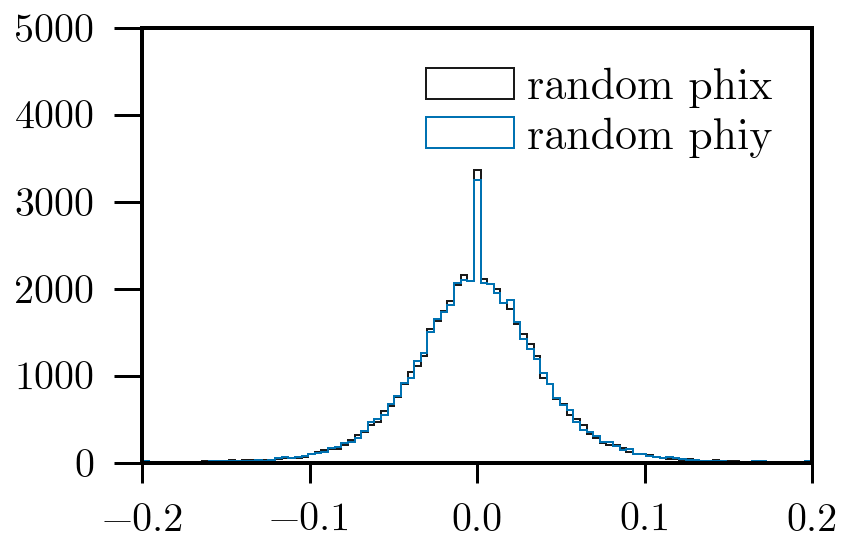

In [299]:
plt.hist(phi_x_pixel_u, bins=101, histtype="step", label="random phix", lw=1, range=(-0.2,0.2));
plt.hist(phi_y_pixel_u, bins=101, histtype="step", label="random phiy", lw=1, range=(-0.2,0.2));
plt.legend()
plt.xlim(-0.2,0.2)
plt.ylim(0,5000)

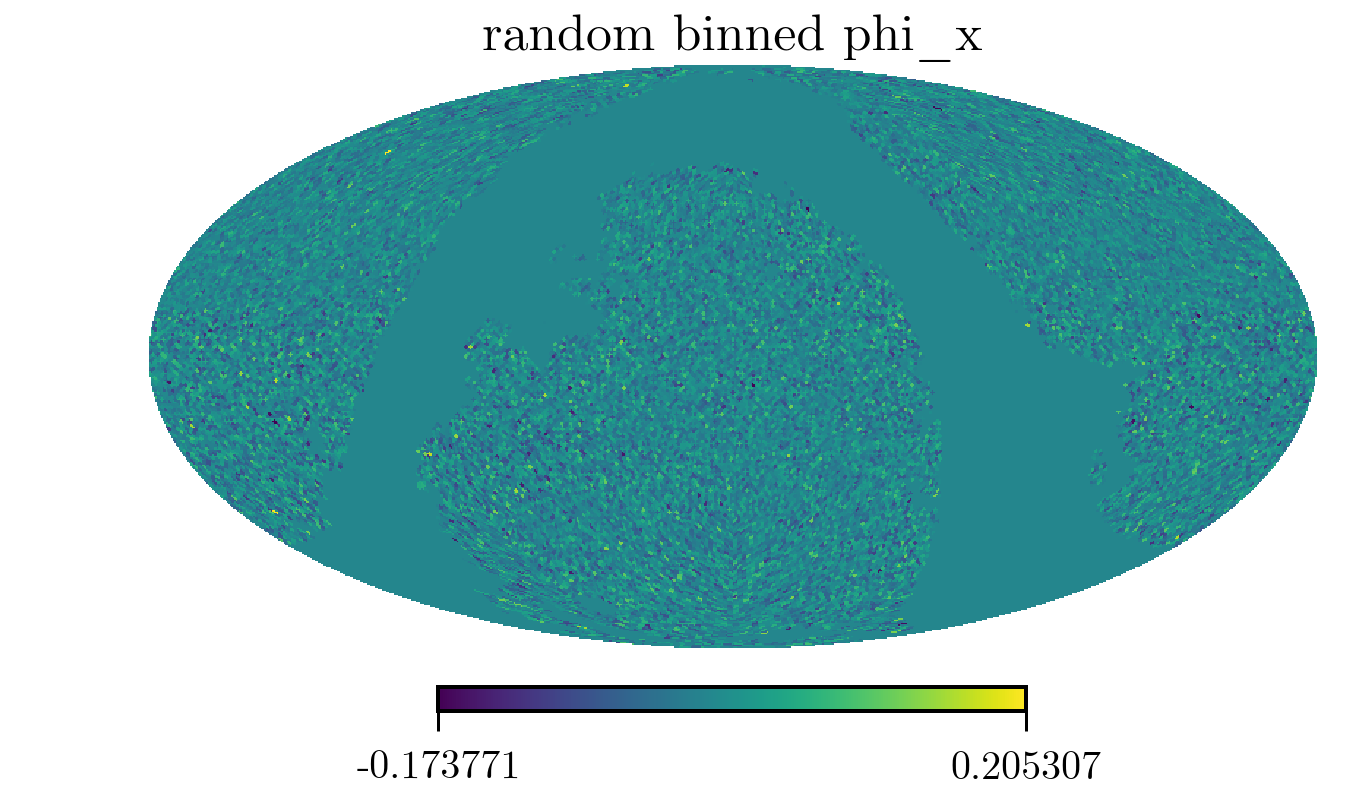

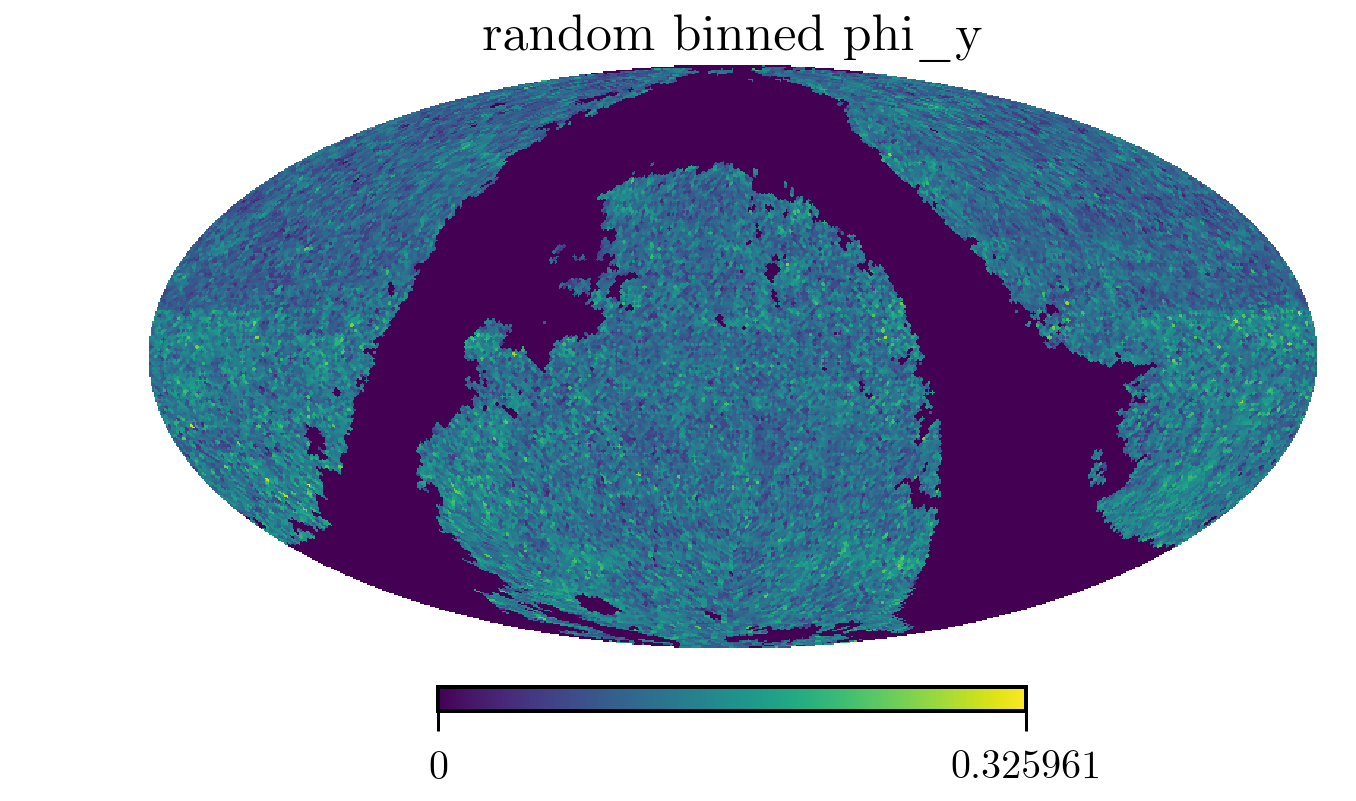

In [301]:
phi_x_pixel_u = np.zeros(npix)
phi_y_pixel_u = np.zeros(npix)

np.add.at(phi_x_pixel_u, pixels_from_angles, uniform_x)
np.add.at(phi_y_pixel_u, pixels_from_angles, uniform_y)

phi_x_pixel_u /= counts_per_pixel
phi_y_pixel_u /= counts_per_pixel
phi_x_pixel_u[counts_per_pixel == 0] = 0.0
phi_y_pixel_u[counts_per_pixel == 0] = 0.0

hp.mollview(phi_x_pixel_u * mask, title="random binned phi_x")
hp.mollview(phi_y_pixel_u * mask, title="random binned phi_y")

(0, 5000)

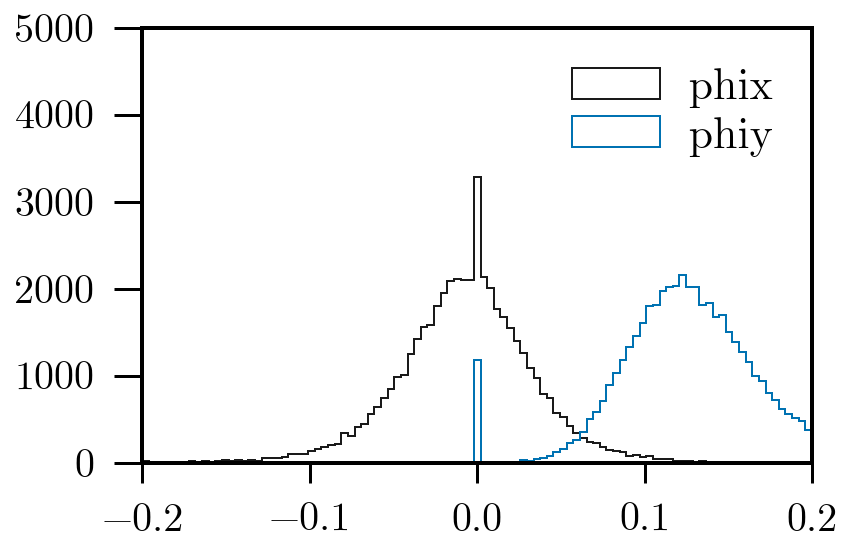

In [304]:
plt.hist(phi_x_pixel, bins=101, histtype="step", label=" phix", lw=1, range=(-0.2,0.2));
plt.hist(phi_y_pixel, bins=101, histtype="step", label=" phiy", lw=1, range=(-0.2,0.2));
plt.legend()
plt.xlim(-0.2,0.2)
plt.ylim(0,5000)

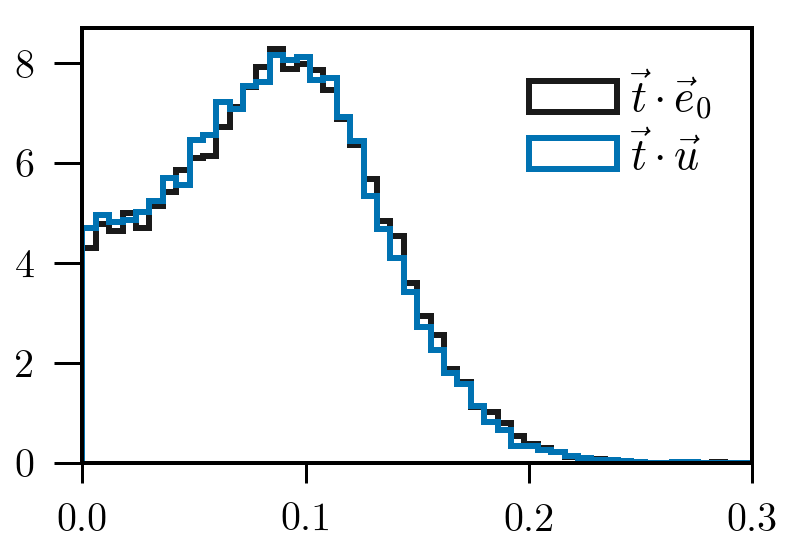

In [308]:
result_dot = np.abs(phi_x_pixel * principal_eigenvectors[:,0] + phi_y_pixel * principal_eigenvectors[:,1])
random_dot = np.abs(phi_x_pixel_u * principal_eigenvectors[:,0] + phi_y_pixel_u * principal_eigenvectors[:,1])

plt.hist( (result_dot)[mask > 0], bins=50, histtype="step", label=r"$\vec{t} \cdot \vec{e}_0$", normed=True, range=(0,0.3) );
plt.hist( (random_dot)[mask > 0], bins=50, histtype="step", label=r"$\vec{t} \cdot \vec{u}$", normed=True, range=(0,0.3) );
plt.xlim(0,0.3)
plt.legend()

In [303]:
principal_eigenvectors[:,0].shape

(49152,)